In [1]:
# Initial settings
%cd ..

import time
import numpy as np
import pandas as pd

from nsopy.utils import flatten_record_dataframe

C:\Users\Robin\projects\smpspy


# Performance Comparison of Dual Methods

## 2. Comparison

For this part, the initial setup is similar to part 1. The method parameters $p$ are now given, and experiments are run over all instances (not just representatives), with those given parameters.

* similar setup to before for results generation; only we go over all instances, and only one parameter
* **Post processing**. for each instance:
    * measure d* (best achieved result over all methods) 
    * measure how many oracle calls to 50%, 10%, 5%, 1%, 0.1%, 0.01% (some may never get there, stay None)

These experiments have been conducted by invoking:
* `python run_final_experiments.py -i parameter_selection.csv -o final_experiment_results.csv`

The results have been stored in `final_experiment_results.csv`. In the following, we do the post processing to get a ranking of how different methods perform on different classes of instances.

## 2.1. Post-Processing, step 1 - compute metrics on convergence speed 

In [2]:
# Import final results dataset
df = pd.read_csv('final_experiments_record.csv')
df = flatten_record_dataframe(df)

c:\users\robin\appdata\local\conda\conda\envs\smps\lib\site-packages\nsopy\utils.py:64: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'd_k', d_k)
c:\users\robin\appdata\local\conda\conda\envs\smps\lib\site-packages\nsopy\utils.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'oracle_calls', oracle_calls)
c:\users\robin\appdata\local\conda\conda\envs\smps\lib\site-packages\nsopy\utils.py:74: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'computation_times', computation_times)


In [3]:
# Generate extra columns in the results df
threshholds = {'50_perc': 0.5, 
               '10_perc': 0.1, 
               '5_perc': 0.05, 
               '1_perc': 0.01, 
               '01_perc': 0.001,
               '001_perc': 0.0001}

for threshhold in threshholds:
    df[threshhold] = np.infty
df['method_d_k_max'] = None

Find 50%, 10%, 1% and 0.1% breakpoints and add them to the dataframe

In [4]:
for instance_name in df.instance_name.unique():
    # Go over all methods used to solve this instance and find best d_k achieved for each method
    methods_d_k_maxima = []
    for index, row in df[df.instance_name == instance_name].iterrows():
        methods_d_k_maxima.append(max(row.d_k))
        df.set_value(index, 'method_d_k_max', methods_d_k_maxima[-1])
    # what's the overall best d_k score across all mthods
    methods_d_k_max = max(methods_d_k_maxima)
    
    # Go over used methods again and filter 50, 10, 1, and 0.1% breaks
    for index, row in df[df.instance_name == instance_name].iterrows():
        for threshhold_tag in threshholds:
            mask = [abs((methods_d_k_max - entry))/abs(methods_d_k_max)<threshholds[threshhold_tag] for entry in row.d_k]
            # print mask
            try:
                oracle_calls_necessary_to_surpass_threshhold = int(row.oracle_calls[mask.index(True)])
            except ValueError:
                oracle_calls_necessary_to_surpass_threshhold = None
            df.set_value(index, threshhold_tag, oracle_calls_necessary_to_surpass_threshhold)
            # print oracle_calls_necessary_to_surpass_threshhold

c:\users\robin\appdata\local\conda\conda\envs\smps\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
c:\users\robin\appdata\local\conda\conda\envs\smps\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Generate column where the perfmance is condensed in one entry

In [5]:
import math
def custom_map(input):
    if math.isnan(input):
        return '--'
    else:
        return int(input)

df['overall_perf'] = df['5_perc'].map(custom_map).map(str) + '/' \
                    + df['1_perc'].map(custom_map).map(str) + '/' \
                    + df['01_perc'].map(custom_map).map(str) + '/' \
                    + df['001_perc'].map(custom_map).map(str)

Pivot table to generate final results:

In [6]:
pvt = df.pivot(index='instance_name', columns='method_name', values='overall_perf')
pvt[[u'SG const', u'SG 1/k', u'TA 1', u'TA 2', u'DSA', u'UPGM', u'UDGM', u'UFGM', u'CP', u'bundle']]

method_name,SG const,SG 1/k,TA 1,TA 2,DSA,UPGM,UDGM,UFGM,CP,bundle
instance_name,,,,,,,,,,
2_dcap233_200,1/96/287/763,1/10/85/581,1/12/--/--,1/15/--/--,1/12/--/--,6/42/--/--,9/67/--/--,14/136/--/--,1/--/--/--,3/27/110/--
2_dcap233_300,1/35/158/--,1/10/56/--,1/10/164/--,1/10/104/--,1/11/126/--,7/31/--/--,11/53/--/--,14/90/--/--,1/--/--/--,4/25/116/237
2_dcap233_500,1/27/79/--,1/13/66/174,1/17/--/--,1/15/--/--,1/13/--/--,7/29/116/--,15/53/--/--,14/88/--/--,1/--/--/--,4/41/--/--
2_semi2,--/--/--/--,7/--/--/--,19/--/--/--,--/--/--/--,17/--/--/--,5/44/44/44,15/47/67/--,20/78/--/--,--/--/--/--,3/13/--/--
2_semi3,--/--/--/--,94/--/--/--,69/--/--/--,39/--/--/--,70/--/--/--,12/--/--/--,13/--/--/--,34/--/--/--,--/--/--/--,36/66/81/81
2_semi4,--/--/--/--,37/--/--/--,1/--/--/--,17/--/--/--,70/--/--/--,6/--/--/--,--/--/--/--,28/--/--/--,--/--/--/--,35/74/100/100
dcap243_200,1/67/234/--,1/6/59/--,1/8/73/493,1/9/98/--,1/8/73/--,5/26/274/--,9/59/--/--,10/224/--/--,1/--/--/--,3/8/83/--
dcap243_300,1/21/149/--,1/7/48/--,1/7/57/--,1/6/56/--,1/7/49/173,6/21/153/--,13/37/--/--,12/60/--/--,1/--/--/--,3/17/108/185
dcap243_500,1/34/106/273,1/10/76/--,1/11/65/--,1/10/66/--,1/9/72/--,6/38/144/--,13/79/--/--,12/--/--/--,1/--/--/--,5/29/--/--


Verify that all methods retrived reasonable dual values:

In [7]:
pvt2 = df.pivot(index='instance_name', columns='method_name', values='method_d_k_max')
pvt2[[u'SG const', u'SG 1/k', u'TA 1', u'TA 2', u'DSA', u'UPGM', u'UDGM', u'UFGM', u'CP', u'bundle']]

method_name,SG const,SG 1/k,TA 1,TA 2,DSA,UPGM,UDGM,UFGM,CP,bundle
instance_name,,,,,,,,,,
2_dcap233_200,1834,1834.12,1831.9,1831.96,1831.78,1832.23,1831.67,1826.81,1784.59,1833.83
2_dcap233_300,1641.73,1642.48,1641.43,1641.71,1641.84,1641.06,1639.87,1638.59,1603.8,1642.78
2_dcap233_500,1735.65,1736.02,1732.05,1733.34,1732.52,1734.34,1732.62,1725.21,1695.11,1734.07
2_semi2,1452.16,1503.85,1509.83,1435.47,1514.68,1538.4,1537.88,1532.08,1421.37,1527.35
2_semi3,1664.74,1676.28,1738.9,1687.01,1735.92,1703.52,1689.47,1680.63,1661.65,1762.76
2_semi4,2033.61,2107.39,2113.08,2065.35,2082.58,2081.53,2039.79,2056.99,2029.69,2148.23
dcap243_200,2318.63,2319.21,2320.19,2319.02,2319.75,2318.92,2317.39,2315.71,2268.12,2319.85
dcap243_300,2554.17,2554.73,2555.2,2555.1,2555.59,2553.34,2552.29,2550.1,2513.59,2555.55
dcap243_500,2163.61,2162.21,2162.59,2162.54,2162.62,2161.58,2148.1,2124.65,2111.77,2161.03


## 2.1. Post-Processing, Step 2 - Compute Methods Ranking

We first define the method that assigns scores:

In [12]:
import operator
from operator import *
from itertools import *

def generate_scores(x):
    sorted_x = sorted(x.items(), key=operator.itemgetter(1))
    ranked_x = [list(g) for _,g in groupby(sorted(sorted_x, key=itemgetter(1)), itemgetter(1))]

    score = []
    rank_score = 1
    all_get_rank_1 = False
    
    for rank_list in ranked_x:
        for id, n_iterations in rank_list:
            if math.isnan(n_iterations):
                score.append((id, 20))
            elif type(n_iterations) in [np.float64, float]:
                if abs(n_iterations-1) <= 0.01:
                    all_get_rank_1 = True
                if all_get_rank_1:
                    score.append((id, 1))
                else:
                    score.append((id, rank_score))
            else:
                print('unrecognized n_iterations number:')
                print(type(n_iterations))
        rank_score += len(rank_list)

    return score

And then compute the scores, and them to the results dataframe `df`

In [13]:
# Initialize new columns with scores
score_columns = []
for threshhold in threshholds:
    score_columns.append(threshhold+'_score')
    df[score_columns[-1]] = np.infty

# Then fill them
for subtype in df.instance_subtype.unique():
    
    for instance_name in df[df.instance_subtype == subtype].instance_name.unique():
        # Get the results from all the methods used to solve this particular instance
        instance_results_df = df[(df.instance_subtype == subtype) & (df.instance_name == instance_name)]
        result_cols = ['method_name',]+list(threshholds.keys())
        results = instance_results_df[result_cols].to_dict()

        # Then score their performance
        for threshhold in threshholds:
            scores = generate_scores(results[threshhold])  
            # returns (id, score):
            # [[(196, 1.0), (260, 1.0), (106, 1.0), (300, 1.0), (145, 1.0), (68, 1.0)],
            #  [(13, 2.0)],
            #  [(497, 7.0)],
            #  [(364, 11.0)],
            #  [(404, 14.0)]]
            # And store result into the df
            for df_entry_id, score in scores:
                column = threshhold+'_score'
                if score == 20:
                        df.loc[df_entry_id, column] = 0
                else:
                    df.loc[df_entry_id, column] = 21-score

In [14]:
df

,date,instance_name,instance_subtype,instance_type,method_desc,method_name,method_parameter,d_k,oracle_calls,computation_times,...,1_perc,01_perc,method_d_k_max,overall_perf,001_perc_score,50_perc_score,5_perc_score,10_perc_score,1_perc_score,01_perc_score
0,01:35.8,sslp_5_25_3_mymod,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[-132.67, -130.33, -129.12, -127.79, -127.78, ...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[0.21, 0.22, 0.38, 0.22, 0.2, 0.32, 0.2, 0.7, ...",...,18.0,29.0,-123,5/18/29/--,0.0,20.0,17.0,20.0,19.0,19.0
1,10:19.1,sslp_5_25_50,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[-165.34, -135.27, -129.62, -132.73, -127.9, -...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[2.9, 3.39, 3.35, 4.07, 3.11, 2.79, 2.49, 3.63...",...,27.0,84.0,-121.57,8/27/84/--,0.0,20.0,19.0,19.0,19.0,20.0
2,41:33.9,sslp_5_25_100,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[-250.5, -151.38, -137.29, -148.46, -140.88, -...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[5.98, 6.08, 4.81, 7.04, 7.5, 6.59, 6.2, 6.73,...",...,61.0,179.0,-127.4,11/61/179/--,0.0,20.0,18.0,20.0,20.0,19.0
3,43:30.4,sslp_10_50_10_mymod,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[-368.8, -359.99, -356.85, -357.18, -354.75, -...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[2.69, 2.9, 3.19, 3.13, 3.17, 3.14, 3.02, 2.57...",...,6.0,25.0,-352.24,2/6/25/--,0.0,20.0,20.0,20.0,20.0,20.0
4,11:59.9,sslp_10_50_50,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[-475.06, -390.04, -380.83, -378.11, -386.05, ...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[11.45, 9.97, 12.6, 12.65, 12.17, 13.26, 15.64...",...,25.0,66.0,-364.89,4/25/66/94,18.0,20.0,20.0,20.0,19.0,19.0
5,05:07.4,sslp_10_50_100,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[-607.5, -389.65, -383.46, -380.29, -378.85, -...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[22.05, 21.15, 22.19, 22.77, 24.28, 24.79, 23....",...,36.0,90.0,-356.25,7/36/90/98,19.0,20.0,20.0,20.0,18.0,19.0
6,42:02.5,sslp_10_50_500,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[-1844.54, -375.65, -392.95, -418.42, -452.79,...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[124.28, 92.13, 99.67, 91.2, 96.64, 104.58, 11...",...,NaN,NaN,-356.42,10/--/--/--,0.0,20.0,20.0,20.0,0.0,0.0
7,46:03.9,sslp_10_50_1000,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[278064.66, 278064.66, 278064.66, 278064.66, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,1.0,1.0,278065,1/1/1/1,20.0,20.0,20.0,20.0,20.0,20.0
8,54:24.4,sslp_10_50_2000,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[274153.07, 274153.07, 274153.07, 274153.07, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,1.0,1.0,274153,1/1/1/1,20.0,20.0,20.0,20.0,20.0,20.0
9,55:11.5,sslp_15_45_5,sslp,smps,"Bundle Method, $\epsilon = 0.01, \mu = 0.5$",bundle,0.01,"[-266.6, -264.8, -265.67, -263.34, -263.52, -2...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[2.65, 3.15, 2.53, 2.36, 2.45, 2.54, 1.88, 2.7...",...,5.0,NaN,-262.4,2/5/--/--,0.0,20.0,20.0,20.0,20.0,0.0


### Plot Results

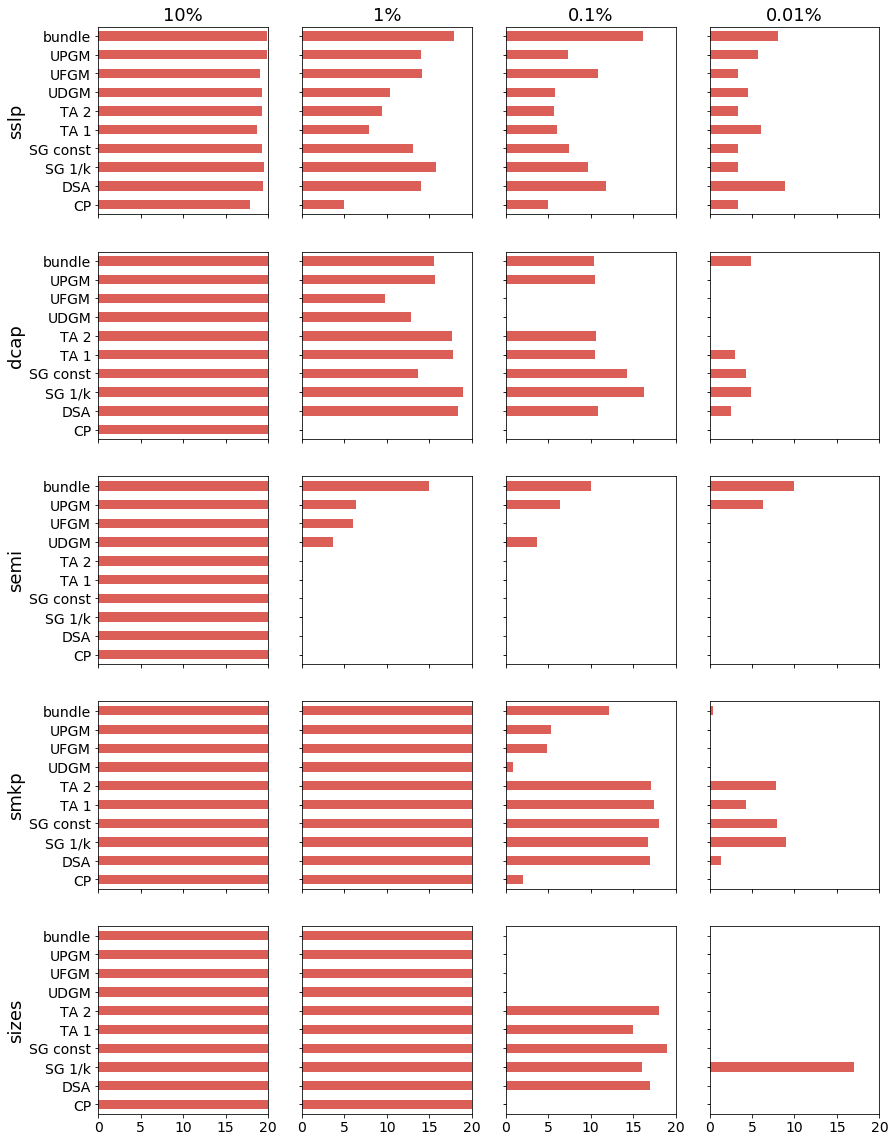

In [15]:
%matplotlib inline
import seaborn as sns
sns.set_palette("hls", 10)
import matplotlib.pyplot as plt

# Optimal: redefine the columns to be plotted
score_columns = ['10_perc_score', '1_perc_score', '01_perc_score', '001_perc_score']
score_column_titles = {
    '10_perc_score': '10%',
    '1_perc_score': '1%',
    '01_perc_score': '0.1%',
    '001_perc_score': '0.01%',

}
instance_subtypes = df.instance_subtype.unique()

fig, axes = plt.subplots(len(instance_subtypes), len(score_columns), figsize=(14, 20)); 
# fig.tight_layout(pad=0.4)  # , w_pad=0.5, h_pad=1.0

for subtype_index, subtype in enumerate(instance_subtypes):
    
    for score_index, score_column in enumerate(score_columns):
        df[df.instance_subtype == subtype].groupby('method_name')[score_column].mean().plot(
            subplots=True, 
            ax=axes[subtype_index][score_index], 
            kind='barh', 
            sharey=True,
            sharex=True,
            fontsize=14
        )
    
    axes[subtype_index][0].set_ylabel(subtype, fontsize=18) # size='large'

#  x Axis is shared, so resize it
for row_index, ax_row in enumerate(axes): 
    for col_index, ax in enumerate(ax_row):
        ax.set_xlim([0, 20])
        # subfigure titles
        if row_index == 0:
            ax.set_title(score_column_titles[score_columns[col_index]], fontsize=18)
        else:
            ax.set_title('', visible=False)

fig.savefig('methods_performance_comparison_results_per_class.pdf', format='PDF', bbox_inches='tight')

### Global performance across all instances

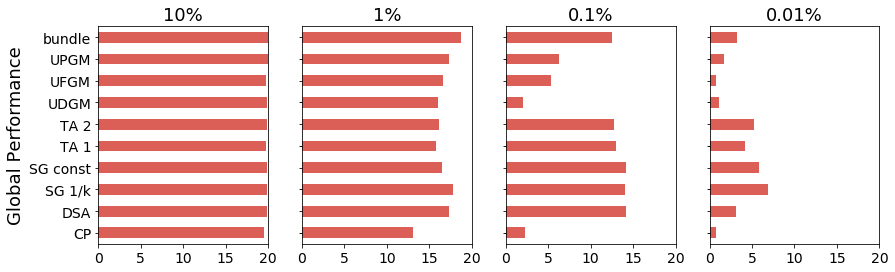

In [16]:
global_fig, global_axes = plt.subplots(1, len(score_columns), figsize=(14, 4)); 

for score_index, score_column in enumerate(score_columns):
    df.groupby('method_name')[score_column].mean().plot(
        subplots=True, 
        ax=global_axes[score_index], 
        kind='barh', 
        sharey=True,
        fontsize=14
    )

global_axes[0].set_ylabel('Global Performance', fontsize=18)

#  x Axis is shared, so resize it
for col_index, ax in enumerate(global_axes):
    ax.set_xlim([0, 20])
    ax.set_title(score_column_titles[score_columns[col_index]], fontsize=18)

global_fig.savefig('methods_performance_comparison_results_global.pdf', format='PDF', bbox_inches='tight')

#### Verification Plots

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("hls", 10)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [4]:
df = pd.read_csv('final_experiments_record.csv')
df = flatten_record_dataframe(df)

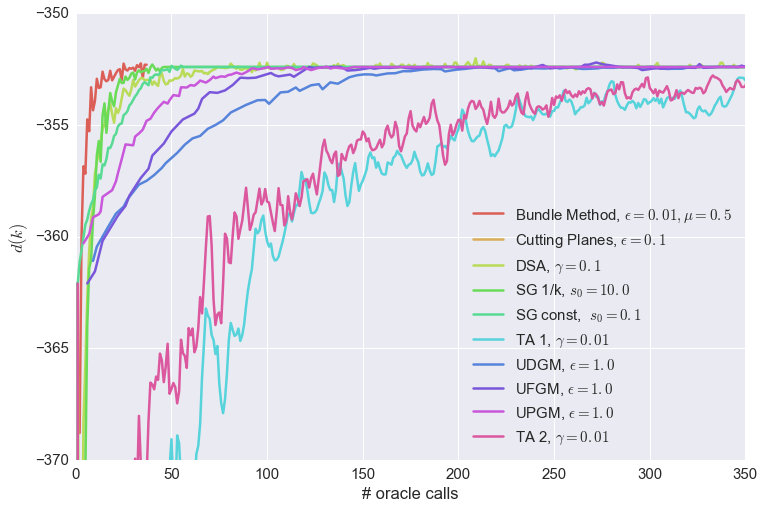

In [62]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

for row in df[df.instance_name == 'sslp_10_50_10_mymod'].iterrows():  # sslp_5_25_100
    plt.plot(row[1]['oracle_calls'], row[1]['d_k'], label=row[1]['method_desc'])

plt.xlim([0,350])
# plt.ylim([-140,-121])
plt.ylim([-370,-350])
plt.ylabel('$d(k)$')
plt.xlabel('# oracle calls')
plt.legend(loc=4)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # outside, to the right
plt.savefig('example_plot.pdf', format='PDF', bbox_inches='tight')

In [ ]:
plt.figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')

for row in df[df.instance_name == '2_semi2'].iterrows():
    plt.plot(row[1]['oracle_calls'], row[1]['d_k'], label=row[1]['method_name'])

# plt.xlim([0,300])
plt.ylim([1400,1600])
plt.legend(loc=4)